In [11]:
import yfinance as yf
import polars as pl
from datetime import datetime, timedelta

# Specify the stock ticker symbol
ticker_symbol = 'AAPL'

# Get the current date and time
end_date = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
start_date = end_date - timedelta(days=2)

# Fetch stock data for the specified ticker
stock_data = yf.Ticker(ticker_symbol)

# Get historical market data (close prices only)
historical_data = stock_data.history(start=start_date, end=end_date, interval='15m')['Close']

# Create a Polars DataFrame
df = pl.DataFrame({
    'unique_id': pl.Series([ticker_symbol] * len(historical_data)),
    'ds': pl.Series(historical_data.index.astype(str)),
    'y': pl.Series(historical_data.values)
})

print(df.head())
print(df.tail())

shape: (5, 3)
┌───────────┬───────────────────────────┬────────────┐
│ unique_id ┆ ds                        ┆ y          │
│ ---       ┆ ---                       ┆ ---        │
│ str       ┆ str                       ┆ f64        │
╞═══════════╪═══════════════════════════╪════════════╡
│ AAPL      ┆ 2024-07-15 09:30:00-04:00 ┆ 234.321304 │
│ AAPL      ┆ 2024-07-15 09:45:00-04:00 ┆ 234.490097 │
│ AAPL      ┆ 2024-07-15 10:00:00-04:00 ┆ 234.854996 │
│ AAPL      ┆ 2024-07-15 10:15:00-04:00 ┆ 234.7901   │
│ AAPL      ┆ 2024-07-15 10:30:00-04:00 ┆ 234.998993 │
└───────────┴───────────────────────────┴────────────┘
shape: (5, 3)
┌───────────┬───────────────────────────┬────────────┐
│ unique_id ┆ ds                        ┆ y          │
│ ---       ┆ ---                       ┆ ---        │
│ str       ┆ str                       ┆ f64        │
╞═══════════╪═══════════════════════════╪════════════╡
│ AAPL      ┆ 2024-07-15 14:45:00-04:00 ┆ 234.783707 │
│ AAPL      ┆ 2024-07-15 15:00:00-04:

In [12]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.lag_transforms import ExpandingMean, RollingMean
import lightgbm as lgb

def hour_index(times):
    return pl.from_pandas(pd.to_datetime(times)).dt.hour()

lgb_params = {
    'verbosity': -1,
    'num_leaves': 31,
}

fcst = MLForecast(
    models=[lgb.LGBMRegressor(**lgb_params)],
    freq='15m',
    target_transforms=[Differences([96])],  # 96 is the number of 15-minute intervals in a day
    lags=[1, 4, 96],  # 1 (last interval), 4 (last hour), 96 (last day)
    lag_transforms={
        1: [ExpandingMean()],
        96: [RollingMean(window_size=96*7)],  # Rolling mean of the last week
    },
    date_features=[hour_index],
)

In [17]:
import yfinance as yf
import polars as pl
from datetime import datetime, timedelta
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.lag_transforms import ExpandingMean, RollingMean
import lightgbm as lgb

# Define hour_index function for Polars
def hour_index(times):
    return times.dt.hour()

# Specify the stock ticker symbol
ticker_symbol = 'AAPL'

# Get the current date and time
end_date = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
start_date = end_date - timedelta(days=2)


day1 = df.filter(pl.col('ds').cast(pl.Date) == first_day)
day2 = df.filter(pl.col('ds').cast(pl.Date) > first_day)

print("Day 1 shape:", day1.shape)
print("Day 2 shape:", day2.shape)

print("\nDay 1 head:")
print(day1.head())

print("\nDay 2 head:")
print(day2.head())

print("\nDay 1 tail:")
print(day1.tail())

print("\nDay 2 tail:")
print(day2.tail())

# Fetch stock data for the specified ticker
stock_data = yf.Ticker(ticker_symbol)

# Get historical market data (close prices only)
historical_data = stock_data.history(start=start_date, end=end_date, interval='15m')['Close']

# Create a Polars DataFrame
df = pl.DataFrame({
    'unique_id': pl.Series([ticker_symbol] * len(historical_data)),
    'ds': pl.Series(historical_data.index),
    'y': pl.Series(historical_data.values)
})

# Convert 'ds' column to datetime
df = df.with_columns(pl.col('ds').cast(pl.Datetime))

print(df.head())
print(df.tail())

lgb_params = {
    'verbosity': -1,
    'num_leaves': 31,
}

fcst = MLForecast(
    models=[lgb.LGBMRegressor(**lgb_params)],
    freq='15m',
    target_transforms=[Differences([96])],  # 96 is the number of 15-minute intervals in a day
    lags=[1, 4, 96],  # 1 (last interval), 4 (last hour), 96 (last day)
    lag_transforms={
        1: [ExpandingMean()],
        96: [RollingMean(window_size=96*7)],  # Rolling mean of the last week
    }
)

# Split the data into two days
split_time = end_date - timedelta(days=1)
day1 = df.filter(pl.col('ds') < split_time)
day2 = df.filter(pl.col('ds') >= split_time)

print(day1.shape)
print(day2.shape)

shape: (5, 3)
┌───────────┬─────────────────────┬────────────┐
│ unique_id ┆ ds                  ┆ y          │
│ ---       ┆ ---                 ┆ ---        │
│ str       ┆ datetime[μs]        ┆ f64        │
╞═══════════╪═════════════════════╪════════════╡
│ AAPL      ┆ 2024-07-15 13:30:00 ┆ 234.321304 │
│ AAPL      ┆ 2024-07-15 13:45:00 ┆ 234.490097 │
│ AAPL      ┆ 2024-07-15 14:00:00 ┆ 234.854996 │
│ AAPL      ┆ 2024-07-15 14:15:00 ┆ 234.7901   │
│ AAPL      ┆ 2024-07-15 14:30:00 ┆ 234.998993 │
└───────────┴─────────────────────┴────────────┘
shape: (5, 3)
┌───────────┬─────────────────────┬────────────┐
│ unique_id ┆ ds                  ┆ y          │
│ ---       ┆ ---                 ┆ ---        │
│ str       ┆ datetime[μs]        ┆ f64        │
╞═══════════╪═════════════════════╪════════════╡
│ AAPL      ┆ 2024-07-15 18:45:00 ┆ 234.783707 │
│ AAPL      ┆ 2024-07-15 19:00:00 ┆ 234.899994 │
│ AAPL      ┆ 2024-07-15 19:15:00 ┆ 234.580002 │
│ AAPL      ┆ 2024-07-15 19:30:00 ┆ 234.0

In [25]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.lag_transforms import ExpandingMean, RollingMean
import lightgbm as lgb
import matplotlib.pyplot as plt
import pytz

# # Define hour_index function for pandas
# def hour_index(times):
#     return times.dt.hour

# Specify the stock ticker symbol
ticker_symbol = 'AAPL'

# Get the current date and time in New York timezone
ny_tz = pytz.timezone('America/New_York')
end_date = datetime.now(ny_tz).replace(hour=0, minute=0, second=0, microsecond=0)
start_date = end_date - timedelta(days=2)

# Fetch stock data for the specified ticker
stock_data = yf.Ticker(ticker_symbol)

# Get historical market data (close prices only)
historical_data = stock_data.history(start=start_date, end=end_date, interval='1m')['Close']

# Create a pandas DataFrame
df = pd.DataFrame({
    'unique_id': [ticker_symbol] * len(historical_data),
    'ds': historical_data.index,
    'y': historical_data.values
})

print(df.head())
print(df.tail())

lgb_params = {
    'verbosity': -1,
    'num_leaves': 31,
}

fcst = MLForecast(
    models=[lgb.LGBMRegressor(**lgb_params)],
    freq='min',
    target_transforms=[Differences([96])],  # 96 is the number of 15-minute intervals in a day
    lags=[1, 4, 96],  # 1 (last interval), 4 (last hour), 96 (last day)
    lag_transforms={
        1: [ExpandingMean()],
        96: [RollingMean(window_size=96*7)],  # Rolling mean of the last week
    },
    # date_features=[hour_index]
)

# Split the data into two days
split_time = end_date - timedelta(days=1)
day1 = df[df['ds'] < split_time]
day2 = df[df['ds'] >= split_time]

print("Day 1 shape:", day1.shape)
print("Day 2 shape:", day2.shape)

print("\nDay 1 head:")
print(day1.head())

print("\nDay 2 head:")
print(day2.head())

print("\nDay 1 tail:")
print(day1.tail())

print("\nDay 2 tail:")
print(day2.tail())

# Train on day 1
fcst.fit(day1)

# Prepare to store predictions
all_predictions = []

# Simulate real-time predictions for day 2
for i in range(len(day2)):
    # Predict the next value
    next_time = day2['ds'].iloc[i]
    pred = fcst.predict(1)
    pred['ds'] = next_time
    all_predictions.append(pred)
    
    # Update the model with the actual value
    actual = day2.iloc[i:i+1]
    fcst.update(actual)

# Combine all predictions
predictions = pd.concat(all_predictions)

# Compare predictions with actuals
comparison = day2.merge(predictions, on=['unique_id', 'ds'], how='left')
comparison['error'] = comparison['y'] - comparison['LGBMRegressor']

print(comparison)

# Calculate RMSE
rmse = (comparison['error'] ** 2).mean() ** 0.5
print(f"RMSE: {rmse}")

# Plot results
plt.figure(figsize=(15, 7))
plt.plot(comparison['ds'], comparison['y'], label='Actual')
plt.plot(comparison['ds'], comparison['LGBMRegressor'], label='Predicted')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

  unique_id                        ds           y
0      AAPL 2024-07-15 09:30:00-04:00  235.690002
1      AAPL 2024-07-15 09:31:00-04:00  236.229996
2      AAPL 2024-07-15 09:32:00-04:00  236.926804
3      AAPL 2024-07-15 09:33:00-04:00  236.189896
4      AAPL 2024-07-15 09:34:00-04:00  236.589905
    unique_id                        ds           y
772      AAPL 2024-07-16 15:55:00-04:00  234.830002
773      AAPL 2024-07-16 15:56:00-04:00  234.780304
774      AAPL 2024-07-16 15:57:00-04:00  234.828598
775      AAPL 2024-07-16 15:58:00-04:00  234.959900
776      AAPL 2024-07-16 15:59:00-04:00  234.809998
Day 1 shape: (389, 3)
Day 2 shape: (388, 3)

Day 1 head:
  unique_id                        ds           y
0      AAPL 2024-07-15 09:30:00-04:00  235.690002
1      AAPL 2024-07-15 09:31:00-04:00  236.229996
2      AAPL 2024-07-15 09:32:00-04:00  236.926804
3      AAPL 2024-07-15 09:33:00-04:00  236.189896
4      AAPL 2024-07-15 09:34:00-04:00  236.589905

Day 2 head:
    unique_id     

c:\Users\wesst\toolkit\tool-kit\.venv\Lib\site-packages\mlforecast\core.py:402: UserWarning: The following series were dropped completely due to the transformations and features: ['AAPL'].
These series won't show up if you use `MLForecast.forecast_fitted_values()`.
You can set `dropna=False` or use transformations that require less samples to mitigate this
  warnings.warn(


ValueError: Input data must be 2 dimensional and non empty.

In [26]:
df

,unique_id,ds,y
0,AAPL,2024-07-15 09:30:00-04:00,235.690002
1,AAPL,2024-07-15 09:31:00-04:00,236.229996
2,AAPL,2024-07-15 09:32:00-04:00,236.926804
3,AAPL,2024-07-15 09:33:00-04:00,236.189896
4,AAPL,2024-07-15 09:34:00-04:00,236.589905
...,...,...,...
772,AAPL,2024-07-16 15:55:00-04:00,234.830002
773,AAPL,2024-07-16 15:56:00-04:00,234.780304
774,AAPL,2024-07-16 15:57:00-04:00,234.828598
775,AAPL,2024-07-16 15:58:00-04:00,234.959900


In [38]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from lightgbm import LGBMRegressor

mlf = MLForecast(
    models=[LGBMRegressor()],
    freq='1min',  # Frequency of your data (1 minute)
    lags=[1, 2, 3, 4, 5],  # Example lags, adjust as needed
    date_features=['hour', 'minute'],  # Relevant date features
    target_transforms=[Differences([1])]  # Example target transform
)

In [39]:
df

,unique_id,ds,y
0,AAPL,2024-07-15 09:30:00-04:00,235.690002
1,AAPL,2024-07-15 09:31:00-04:00,236.229996
2,AAPL,2024-07-15 09:32:00-04:00,236.926804
3,AAPL,2024-07-15 09:33:00-04:00,236.189896
4,AAPL,2024-07-15 09:34:00-04:00,236.589905
...,...,...,...
772,AAPL,2024-07-16 15:55:00-04:00,234.830002
773,AAPL,2024-07-16 15:56:00-04:00,234.780304
774,AAPL,2024-07-16 15:57:00-04:00,234.828598
775,AAPL,2024-07-16 15:58:00-04:00,234.959900


In [37]:
df.dtypes

unique_id                              object
ds           datetime64[ns, America/New_York]
y                                     float64
dtype: object

In [40]:
mlf.fit(df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 771, number of used features: 7
[LightGBM] [Info] Start training from score -0.001816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

MLForecast(models=[LGBMRegressor], freq=1min, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5'], date_features=['hour', 'minute'], num_threads=1)

In [ ]:


for i in range(len(test_data)):
    # Make a one-step ahead prediction
    pred = mlf.predict(1)
    print(f"Prediction for next minute: {pred['LGBMRegressor'].values[0]}")
    
    # Update the model with the actual value
    mlf.update(test_data.iloc[i:i+1])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1551
[LightGBM] [Info] Number of data points in the train set: 560, number of used features: 10
[LightGBM] [Info] Start training from score -0.002636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\wesst\toolkit\tool-kit\.venv\Lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


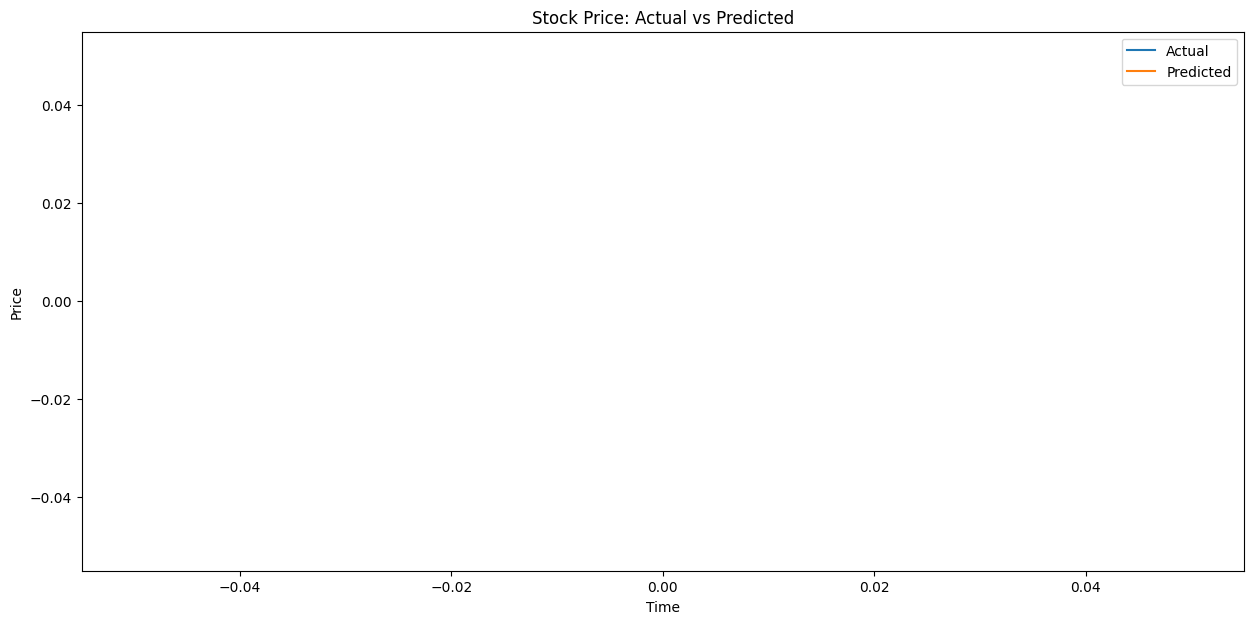

In [57]:
import pandas as pd
import numpy as np
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.dates as mdates
import time

# Assuming df is your full dataset
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

mlf = MLForecast(
    models=[LGBMRegressor()],
    freq='1min',
    lags=[1, 2, 3, 4, 5, 15, 30, 60],
    date_features=['hour', 'minute'],
    target_transforms=[Differences([1])]
)

# Fit the model on the training data
mlf.fit(train_df)


fig, ax = plt.subplots(figsize=(15, 7))
line_actual, = ax.plot([], [], label='Actual')
line_pred, = ax.plot([], [], label='Predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Stock Price: Actual vs Predicted')
ax.legend()

# Initialize animation setup
times = []
actual_prices = []
predicted_prices = []
frame = 0

def update(i):
    global frame
    if frame < len(test_df):
        next_data = test_df.iloc[frame]
        pred = mlf.predict(1)
        pred_value = pred['LGBMRegressor'].values[0]
        mlf.update(next_data.to_frame().T)
        times.append(next_data['ds'])
        actual_prices.append(next_data['y'])
        predicted_prices.append(pred_value)
        line_actual.set_data(times, actual_prices)
        line_pred.set_data(times, predicted_prices)
        ax.set_xlim(min(times), max(times))
        ax.set_ylim(min(min(actual_prices), min(predicted_prices)),
                    max(max(actual_prices), max(predicted_prices)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
        plt.xticks(rotation=45)
        fig.tight_layout()
        frame += 1

# Assign animation and show it
ani = FuncAnimation(fig, update, frames=len(test_df), interval=100, repeat=False)
plt.show()

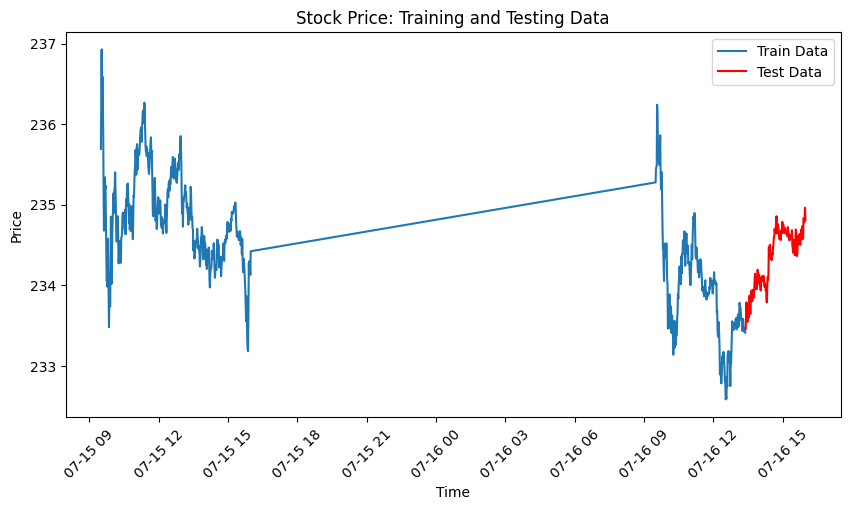

In [58]:
# Simple plot to check if data loads correctly
plt.figure(figsize=(10, 5))
plt.plot(train_df['ds'], train_df['y'], label='Train Data')
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price: Training and Testing Data')
plt.legend()
plt.xticks(rotation=45)
plt.show()
